

# <span style="color: #3498db;">CA2 - Minmax Algorithm </span>

**<span style="color:rgb(247, 169, 0);">[AhmadReza Nopoush]</span> - <span style="color:rgb(26, 203, 20);">[610301194]</span>**



### **<span style="color:rgb(223, 9, 84);">[Initialization]</span>**

importing libraries...

In [1]:
import matplotlib.pyplot as plt
import random
import numpy as np
from math import inf
import time
import pygame
from matplotlib.collections import LineCollection

pygame 2.6.1 (SDL 2.28.4, Python 3.13.0)
Hello from the pygame community. https://www.pygame.org/contribute.html


main class...

In [2]:
class PentagoGame:
    def __init__(self, ui=False, print=False, depth=2):
        self.board = np.zeros((6, 6), dtype=int)
        self.current_player = 1
        self.ui = ui
        self.depth = depth
        self.nodes_visited = 0
        self.game_over = False
        self.result = None
        self.selected_block = None
        self.move_stage = 0  # 0: place piece, 1: select block, 2: rotate
        self.temp_piece = None
        self.print = print
        self.information = []

        if ui:
            pygame.font.init()
            self.screen = pygame.display.set_mode((800, 600))
            pygame.display.set_caption("Pygame Board")
            # self.font = pygame.font.SysFont("Arial", 20)
            self.show_buttons = False
            self.buttons = {
                "rotate_cw": pygame.Rect(650, 200, 100, 50),
                "rotate_ccw": pygame.Rect(650, 300, 100, 50),
            }
            self.setup_controls()
            self.draw_board()

    def setup_controls(self):
        if self.show_buttons:
            pygame.draw.rect(self.screen, (144, 238, 144), self.buttons["rotate_cw"])   # Light Green
            pygame.draw.rect(self.screen, (173, 216, 230), self.buttons["rotate_ccw"])  # Light Blue

            self.screen.draw_text("CLOCKWISE", self.buttons["rotate_cw"].center)
            self.screen.draw_text("COUNTER-CLOCKWISE", self.buttons["rotate_ccw"].center)

    def hide_rotation_buttons(self):
        self.show_buttons = False

    def show_rotation_buttons(self):
        self.show_buttons = True

    def copy_board(self, board):
        return np.copy(board)

    def rotate_block(self, board, block, direction):
        row_start = (block // 2) * 3
        col_start = (block % 2) * 3
        sub = board[row_start : row_start + 3, col_start : col_start + 3]
        rotated = np.rot90(sub, 3 if direction == "cw" else 1)
        board[row_start : row_start + 3, col_start : col_start + 3] = rotated

    def get_possible_moves(self, board, player):
        moves = []
        for i in range(6):
            for j in range(6):
                if board[i][j] == 0:
                    for block in range(4):
                        for dir in ["cw", "ccw"]:
                            moves.append((i, j, block, dir))
        return moves

    def apply_move(self, board, move, player):
        new_board = self.copy_board(board)
        row, col, block, direction = move
        if new_board[row][col] != 0:
            return None
        new_board[row][col] = player
        self.rotate_block(new_board, block, direction)
        return new_board

    def check_winner(self, board):
        for i in range(6):
            for j in range(6):
                if board[i][j] == 0:
                    continue

                # Horizontal
                if j <= 1 and np.all(board[i, j : j + 5] == board[i][j]):
                    return board[i][j]

                # Vertical
                if i <= 1 and np.all(board[i : i + 5, j] == board[i][j]):
                    return board[i][j]

                # Diagonal
                if (
                    i <= 1
                    and j <= 1
                    and all(board[i + k][j + k] == board[i][j] for k in range(5))
                ):
                    return board[i][j]

                # Anti-diagonal
                if (
                    i <= 1
                    and j >= 4
                    and all(board[i + k][j - k] == board[i][j] for k in range(5))
                ):
                    return board[i][j]
        if np.all(board != 0):
            return 0
        return None

    def heuristic(self,board) -> int:
        winner = self.check_winner(board)
        if winner == 1:
            return -inf
        if winner == -1:
            return inf
        
        #Scores:
        Seq_4 = 1000
        Seq_3 = 100
        Seq_center = 5

        Score = (-1*Seq_center*(board[1][1]+board[4][1]+board[1][4]+board[4][4]))

        for i in range(6):
            for j in range(6):
                if board[i][j] == 0:
                    continue
                # Horizontal
                if (j==0 or j==3):
                    if np.all(board[i, j : j + 3] == board[i][j]):
                        Score += (2*board[i][j]*-1*Seq_3)
                # Vertical
                if (i==0 or i==3):
                    if np.all(board[i : i + 3, j] == board[i][j]):
                        Score += (2*board[i][j]*-1*Seq_3)
                # Diagonal
                if  ((i==0 and j==0) or (i==3 and j==0) or (i==0 and j==3) or (i==3 and j==3)):
                    if all(board[i + k][j + k] == board[i][j] for k in range(3)):
                        Score += (board[i][j]*-1*Seq_3)
                # Anti-diagonal
                if  ((i==0 and j==2) or (i==0 and j==5) or (i==3 and j==2) or (i==3 and j==5)):
                    if all(board[i + k][j - k] == board[i][j]for k in range(3)):
                        Score += (board[i][j]*-1*Seq_3)
                    
                # Horizontal
                if j <= 2:
                    if np.all(board[i, j : j + 4] == board[i][j]):
                        Score += (board[i][j]*-2*Seq_4)
                # Vertical
                if i <= 2: 
                    if np.all(board[i : i + 4, j] == board[i][j]):
                        Score += (board[i][j]*-2*Seq_4)
                # Diagonal
                if  i<=2 and j<=2:
                    if all(board[i + k][j + k] == board[i][j] for k in range(4)):
                        Score += (board[i][j]*-1*Seq_4)
                # Anti-diagonal
                if i<=2 and j>=3:
                    if all(board[i + k][j - k] == board[i][j] for k in range(4)):
                        Score += (board[i][j]*-1*Seq_4)

        return Score

    #TODO: Implement minmax algorithm
    def minimax(self, depth, board, player): # -> must return a number
        self.nodes_visited += 1

        winner = self.check_winner(board)
        if winner == 0:
            return 0
        if winner == 1:
            return -1*np.inf
        if winner == -1:
            return np.inf
        
        if depth == 0:
            utility = self.heuristic(board)
            return utility
        
        if player == 1:
            v = np.inf
            moves = self.get_possible_moves(board, 1)
            if not moves:
                return 0 
            for move in moves:
                successor = self.apply_move(board,move,1)
                successorScore = self.minimax(depth-1, successor, -1)
                if successorScore < v:
                    v = successorScore
            return v
        if player == -1:
            v = -1*np.inf
            moves = self.get_possible_moves(board, -1)
            if not moves:
                return 0            
            for move in moves:
                successor = self.apply_move(board,move,-1)
                successorScore = self.minimax(depth-1, successor, 1)
                if successorScore > v:
                    v = successorScore
            return v
        
    def alphaBeta(self, depth, board, player,Alpha,Beta): # -> must return a number
        alpha , beta = Alpha , Beta
        self.nodes_visited += 1
        winner = self.check_winner(board)
        if winner == 0:
            return 0
        if winner == 1:
            return -1*np.inf
        if winner == -1:
            return np.inf
        
        if depth == 0:
            utility = self.heuristic(board)
            return utility
        
        
        moves = self.get_possible_moves(board, player)
        if not moves:
            return 0 
        if player == 1:
            v = np.inf
            for move in moves:
                successor = self.apply_move(board,move,1)
                successorScore = self.alphaBeta(depth-1, successor, -1 ,alpha,beta)
                v = min(v, successorScore)
                if v <=  alpha:
                    break
                beta = min(beta,v)
            return v

        if player == -1:  
            v = -1*np.inf     
            for move in moves:
                successor = self.apply_move(board,move,-1)
                successorScore = self.alphaBeta(depth-1, successor, 1 ,alpha,beta)
                v = max(v,successorScore)
                if v >= beta:
                    break
                alpha = max(alpha,v)
            return v

    def get_computer_move(self, pruning):
        start_time = time.time()
        best_move = None
        best_value = -inf
        depth = self.depth
        
        moves = self.get_possible_moves(self.board, -1)
        if not moves:
            return None
        best_move = moves[0]
        alpha = -1 * np.inf
        beta = np.inf

        for move in moves:
            if self.game_over:
                break
            new_board = self.apply_move(self.board, move, -1)
            if new_board is None:
                continue

            try:
                #TODO: Implement alpha-beta pruning algorithm
                if pruning:
                    depth -= 1
                    value = self.alphaBeta(depth,new_board,1,alpha,beta)
                    depth += 1
                else:
                    depth -= 1
                    value = self.minimax(depth,new_board,1)
                    depth += 1
                
            except:
                value = -inf

            if value > best_value:
                best_value = value
                best_move = move

            if pruning and best_value>= beta:
                break

            if pruning:
                alpha = max(alpha, best_value)

        self.information.append(tuple([len(self.information)+1, time.time()-start_time, self.nodes_visited]))
        if self.print == True:
            print(f"Move took {time.time()-start_time:.2f}s, nodes visited: {self.nodes_visited}")
        self.nodes_visited = 0
        return best_move

    def draw_text(self, text, center_pos, max_width):
        font_size = 24
        font = pygame.font.Font(None, font_size)
        text_surface = font.render(text, True, (0, 0, 0))

        text_width = text_surface.get_width()
        if text_width > max_width:
            scale_factor = max_width / text_width
            new_font_size = int(font_size * scale_factor)
            font = pygame.font.Font(None, new_font_size)
            text_surface = font.render(text, True, (0, 0, 0))

        text_rect = text_surface.get_rect(center=center_pos)
        self.screen.blit(text_surface, text_rect)

    def draw_board(self):
        self.screen.fill((0, 0, 0))

        for i in range(6):
            for j in range(6):
                x0 = j * 100
                y0 = i * 100

                if self.board[i][j] == 1:
                    pygame.draw.circle(self.screen, (255, 0, 0), (x0 + 50, y0 + 50), 40)
                elif self.board[i][j] == -1:
                    pygame.draw.circle(self.screen, (0, 0, 255), (x0 + 50, y0 + 50), 40)

                pygame.draw.rect(self.screen, (255, 255, 255), (x0, y0, 100, 100), 1)

        for i in [3, 6]:
            pygame.draw.line(self.screen, (255, 255, 255), (0, i * 100), (600, i * 100), 3)  # Horizontal
            pygame.draw.line(self.screen, (255, 255, 255), (i * 100, 0), (i * 100, 600), 3)  # Vertical

        # Show rotation buttons if in move_stage 2
        if self.move_stage == 2:
            self.highlight_selected_block()
            self.show_rotation_buttons()

        if self.show_buttons:
            pygame.draw.rect(self.screen, (144, 238, 144), self.buttons["rotate_cw"])  # Light Green
            pygame.draw.rect(self.screen, (173, 216, 230), self.buttons["rotate_ccw"])  # Light Blue

            self.draw_text(
                "CLOCKWISE",
                self.buttons["rotate_cw"].center,
                self.buttons["rotate_cw"].width,
            )
            self.draw_text(
                "COUNTER-CLOCKWISE",
                self.buttons["rotate_ccw"].center,
                self.buttons["rotate_ccw"].width,
            )

    def click_handler(self, event):
        if self.game_over or self.current_player != 1:
            return

        x, y = event.pos
        if self.move_stage == 0:  # Place piece
            if x > 600:
                return  # clicks on control area
            col = x // 100
            row = y // 100
            if 0 <= row < 6 and 0 <= col < 6 and self.board[row][col] == 0:
                self.temp_piece = (row, col)
                self.board[row][col] = 1
                self.move_stage = 1
                self.draw_board()

        elif self.move_stage == 1:  # Select block
            if x > 600:
                return
            # which block was clicked
            block_x = 0 if x < 300 else 1
            block_y = 0 if y < 300 else 1
            self.selected_block = block_y * 2 + block_x
            self.move_stage = 2
            self.show_rotation_buttons()
            self.highlight_selected_block()

        elif self.move_stage == 2:  # Rotate
            if self.buttons["rotate_cw"].collidepoint(event.pos):
                self.apply_rotation("cw")
            if self.buttons["rotate_ccw"].collidepoint(event.pos):
                self.apply_rotation("ccw")

    def apply_rotation(self, direction):
        self.rotate_block(self.board, self.selected_block, direction)
        self.current_player = -1
        self.move_stage = 0
        self.selected_block = None
        self.temp_piece = None
        self.hide_rotation_buttons()
        self.draw_board()
        pygame.display.flip()
        self.check_game_over()
        pygame.time.delay(1000)
        self.play_computer_move()

    def highlight_selected_block(self):
        colors = [
            (255, 153, 153),
            (153, 255, 153),
            (153, 153, 255),
            (255, 255, 153),
        ]  # RGB colors

        row_start = (self.selected_block // 2) * 3
        col_start = (self.selected_block % 2) * 3

        pygame.draw.rect(
            self.screen,
            colors[self.selected_block],
            (col_start * 100, row_start * 100, 300, 300),
            5,
        )

    def play_computer_move(self):
        move = self.get_computer_move()
        if move and not self.game_over:
            new_board = self.apply_move(self.board, move, -1)
            if new_board is not None:
                self.board = new_board
                self.current_player = 1
                self.draw_board()
                pygame.display.flip()
                self.check_game_over()
            else:
                print("Invalid computer move!")

    def check_game_over(self):
        winner = self.check_winner(self.board)
        if winner is not None:
            self.game_over = True
            self.result = winner
            print("Game over! Result:", winner)
            if self.ui:
                self.show_game_over_message()

    def show_game_over_message(self):
        self.screen.fill((200, 200, 200))
        pygame.draw.rect(self.screen, (255, 255, 255), (100, 200, 500, 200))
        pygame.draw.rect(self.screen, (0, 0, 0), (100, 200, 500, 200), 3)

        result_text = f"Player {self.result} wins!" if self.result != 0 else "Draw!"
        text_surface = self.font_large.render(result_text, True, (255, 0, 0))
        self.screen.blit(text_surface, (250, 250))

        exit_text = self.font_small.render("Click anywhere to exit", True, (0, 0, 0))
        self.screen.blit(exit_text, (230, 350))
        pygame.display.flip()

    def play(self, pruning):
        if self.ui:
            running = True
            while running:
                for event in pygame.event.get():
                    if event.type == pygame.QUIT:
                        running = False
                    elif event.type == pygame.MOUSEBUTTONDOWN:
                        self.click_handler(event)
                self.draw_board()
                pygame.display.flip()
            pygame.quit()
            return self.result
        else:
            while not self.game_over:
                self.print_board()
                winner = self.check_winner(self.board)
                if winner is not None:
                    return winner

                if self.current_player == 1:
                    move = random.choice(self.get_possible_moves(self.board, 1))
                else:
                    move = self.get_computer_move(pruning)

                self.board = self.apply_move(self.board, move, self.current_player)
                self.current_player *= -1
            return self.result

    def print_board(self):
        if self.print == False:
            return
        print("-" * 25)
        for row in self.board:
            print(" ".join(f"{x:2}" for x in row))
        print("-" * 25)

### **<span style="color:rgb(223, 9, 84);">[Notes on Implementation]</span>**

### **<span style="color:rgb(223, 9, 84);">[Running]</span>**

#### **<span style="color:rgb(0, 225, 225);">[Minimax: depth=1]</span>**

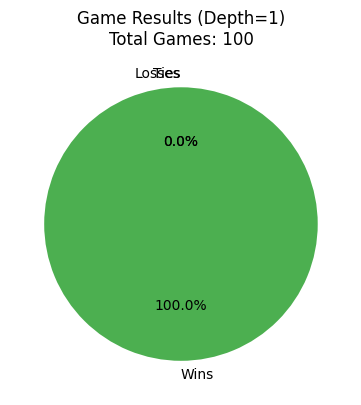

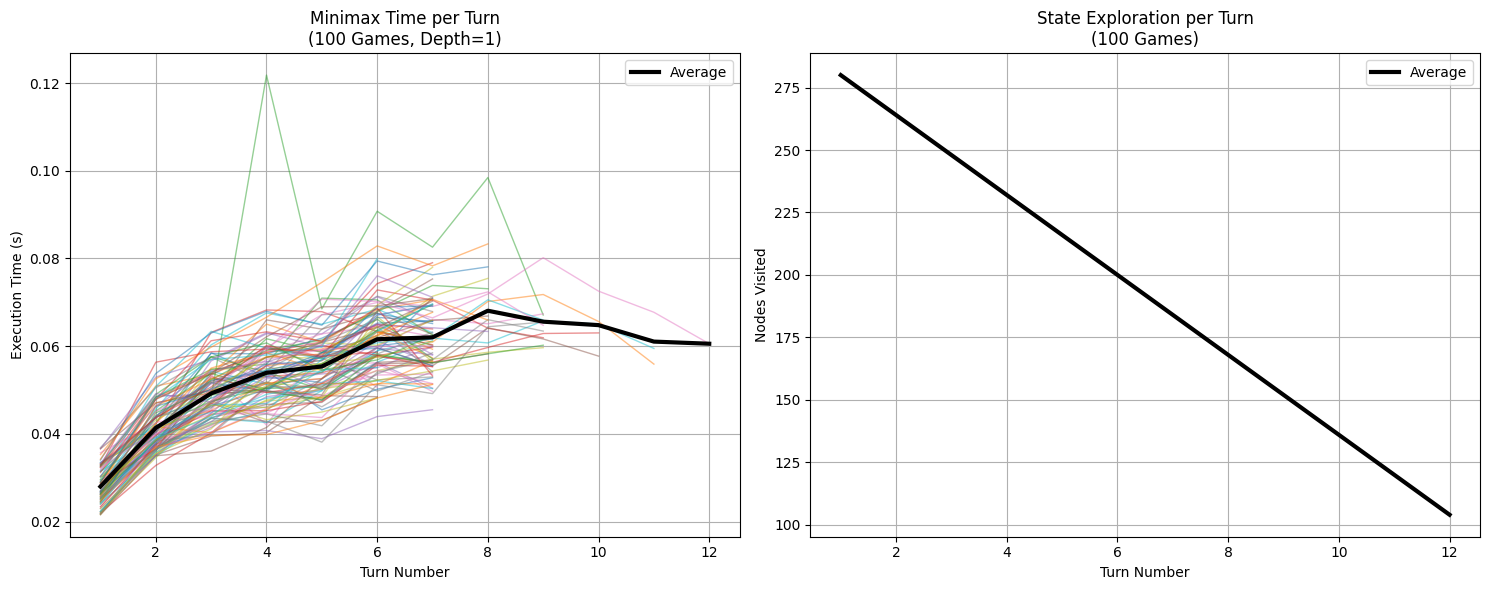

In [6]:
numGames = 100
depth = 1
numWins, numTies, numLosses = 0, 0, 0
all_games_metrics = []

for i in range(numGames):
    game = PentagoGame(ui=False, print=False, depth=depth)
    result = game.play(pruning=False)
    if result == -1:
        numWins += 1
    elif result == 0:
        numTies += 1
    else:
        numLosses += 1
    all_games_metrics.append(game.information)

# 1. Win/Lose/Tie Pie Chart
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
results = [numWins, numLosses, numTies]
labels = ['Wins', 'Losses', 'Ties']
colors = ['#4CAF50', '#F44336', '#FFC107']
plt.pie(results, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title(f'Game Results (Depth={depth})\nTotal Games: {numGames}')

# 1. Prepare Time/Nodes Data
max_turns = max(len(metrics) for metrics in all_games_metrics)
time_matrix = np.full((numGames, max_turns), np.nan)
nodes_matrix = np.full((numGames, max_turns), np.nan)

for i, metrics in enumerate(all_games_metrics):
    for j, m in enumerate(metrics):
        time_matrix[i,j] = m[1]
        nodes_matrix[i,j] = m[2]

# 2. Create Figure
plt.figure(figsize=(15, 6))

# Time Plot
plt.subplot(1, 2, 1)
for i in range(numGames):
    turns = np.arange(len(all_games_metrics[i])) + 1
    plt.plot(turns, time_matrix[i,:len(turns)], 
             alpha=0.5, linewidth=1)
    
# Add mean trendline
mean_time = np.nanmean(time_matrix, axis=0)
valid_turns = ~np.isnan(mean_time)
plt.plot(np.arange(max_turns)[valid_turns]+1, mean_time[valid_turns], 
         'k-', linewidth=3, label='Average')

plt.xlabel('Turn Number')
plt.ylabel('Execution Time (s)')
plt.title(f'Minimax Time per Turn\n({numGames} Games, Depth={depth})')
plt.grid(True)
plt.legend()

# Nodes Plot
plt.subplot(1, 2, 2)
for i in range(numGames):
    turns = np.arange(len(all_games_metrics[i])) + 1
    plt.plot(turns, nodes_matrix[i,:len(turns)], 
             alpha=0.5, linewidth=1)

# Add mean trendline
mean_nodes = np.nanmean(nodes_matrix, axis=0)
plt.plot(np.arange(max_turns)[valid_turns]+1, mean_nodes[valid_turns], 
         'k-', linewidth=3, label='Average')

plt.xlabel('Turn Number')
plt.ylabel('Nodes Visited')
plt.title(f'State Exploration per Turn\n({numGames} Games)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

#### **<span style="color:rgb(0, 225, 225);">[Minimax: depth=2]</span>**

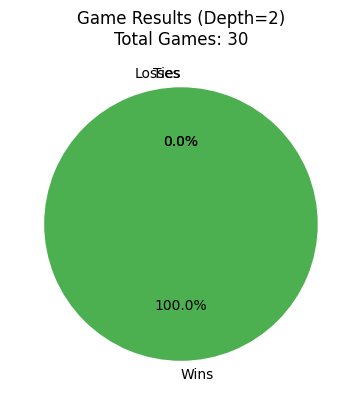

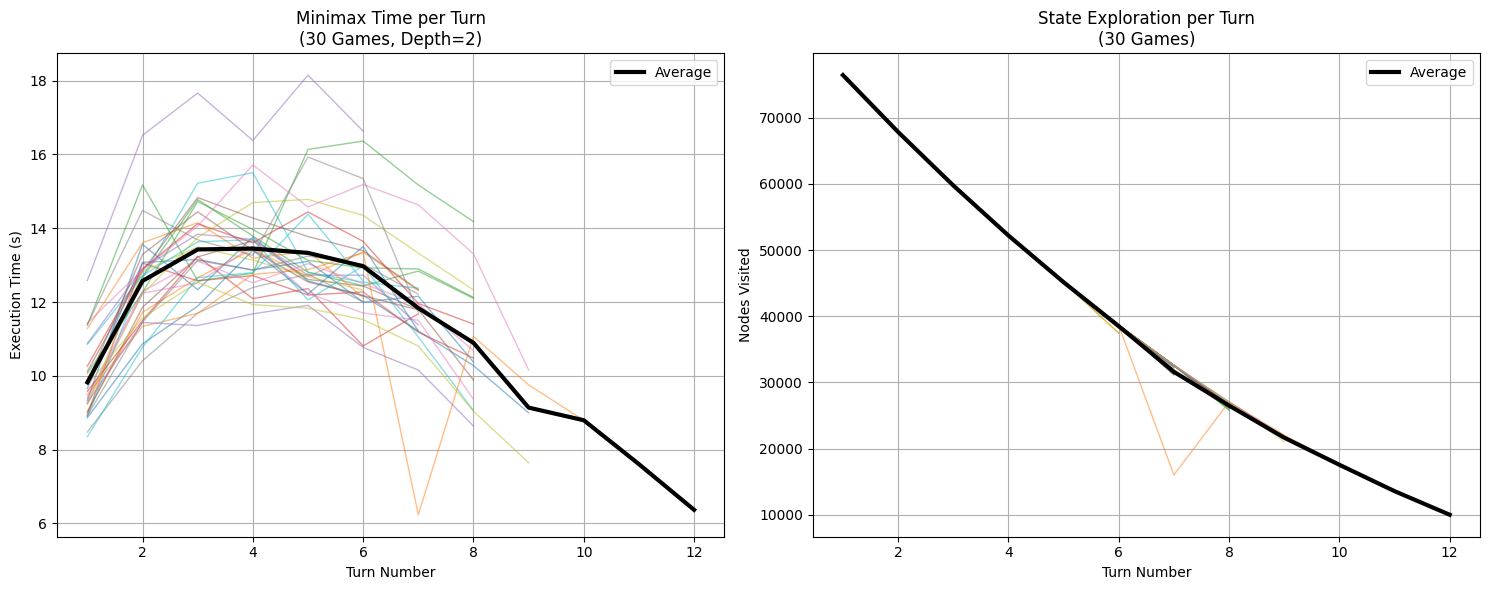

In [4]:
numGames = 30
depth = 2
numWins, numTies, numLosses = 0, 0, 0
all_games_metrics = []

for i in range(numGames):
    game = PentagoGame(ui=False, print=False, depth=depth)
    result = game.play(pruning=False)
    if result == -1:
        numWins += 1
    elif result == 0:
        numTies += 1
    else:
        numLosses += 1
    all_games_metrics.append(game.information)

# 1. Win/Lose/Tie Pie Chart
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
results = [numWins, numLosses, numTies]
labels = ['Wins', 'Losses', 'Ties']
colors = ['#4CAF50', '#F44336', '#FFC107']
plt.pie(results, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title(f'Game Results (Depth={depth})\nTotal Games: {numGames}')

# 1. Prepare Time/Nodes Data
max_turns = max(len(metrics) for metrics in all_games_metrics)
time_matrix = np.full((numGames, max_turns), np.nan)
nodes_matrix = np.full((numGames, max_turns), np.nan)

for i, metrics in enumerate(all_games_metrics):
    for j, m in enumerate(metrics):
        time_matrix[i,j] = m[1]
        nodes_matrix[i,j] = m[2]

# 2. Create Figure
plt.figure(figsize=(15, 6))

# Time Plot
plt.subplot(1, 2, 1)
for i in range(numGames):
    turns = np.arange(len(all_games_metrics[i])) + 1
    plt.plot(turns, time_matrix[i,:len(turns)], 
             alpha=0.5, linewidth=1)
    
# Add mean trendline
mean_time = np.nanmean(time_matrix, axis=0)
valid_turns = ~np.isnan(mean_time)
plt.plot(np.arange(max_turns)[valid_turns]+1, mean_time[valid_turns], 
         'k-', linewidth=3, label='Average')

plt.xlabel('Turn Number')
plt.ylabel('Execution Time (s)')
plt.title(f'Minimax Time per Turn\n({numGames} Games, Depth={depth})')
plt.grid(True)
plt.legend()

# Nodes Plot
plt.subplot(1, 2, 2)
for i in range(numGames):
    turns = np.arange(len(all_games_metrics[i])) + 1
    plt.plot(turns, nodes_matrix[i,:len(turns)], 
             alpha=0.5, linewidth=1)

# Add mean trendline
mean_nodes = np.nanmean(nodes_matrix, axis=0)
plt.plot(np.arange(max_turns)[valid_turns]+1, mean_nodes[valid_turns], 
         'k-', linewidth=3, label='Average')

plt.xlabel('Turn Number')
plt.ylabel('Nodes Visited')
plt.title(f'State Exploration per Turn\n({numGames} Games)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

#### **<span style="color:rgb(0, 225, 225);">[Alphabeta: depth=1]</span>**

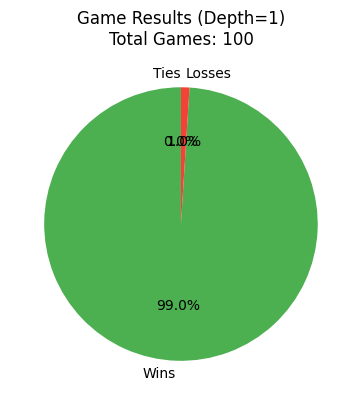

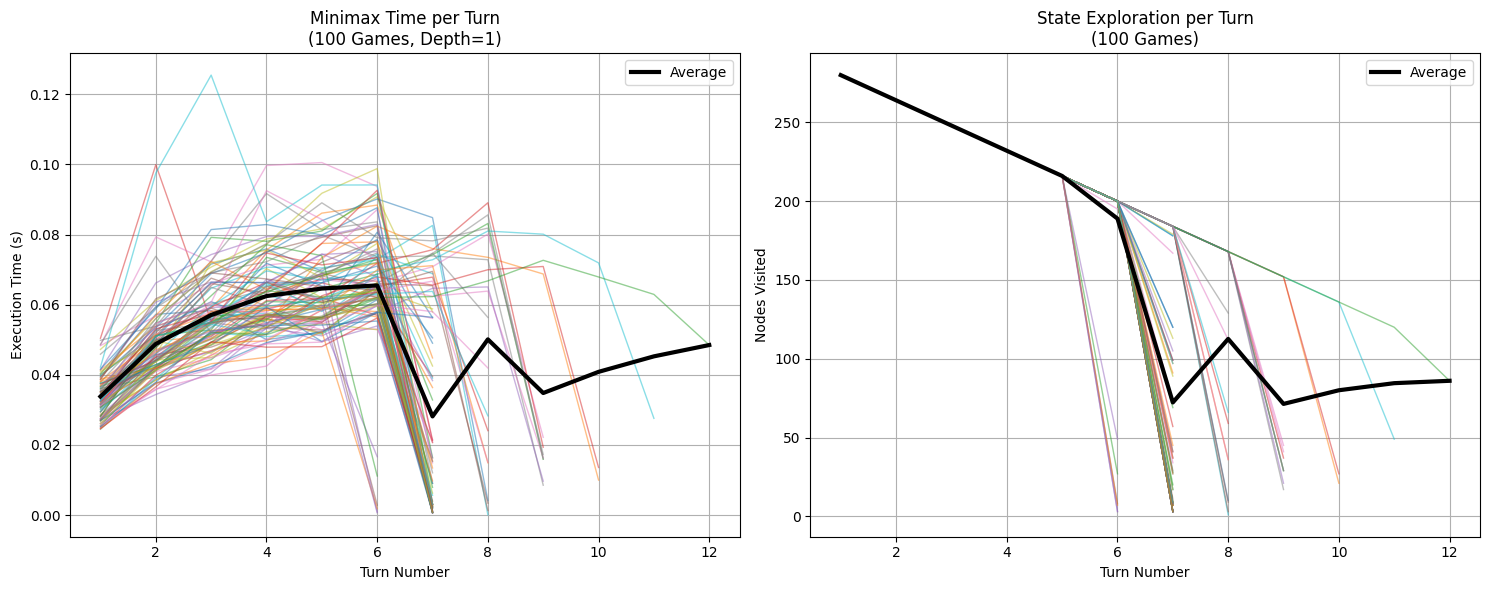

In [4]:
numGames = 100
depth = 1
numWins, numTies, numLosses = 0, 0, 0
all_games_metrics = []

for i in range(numGames):
    game = PentagoGame(ui=False, print=False, depth=depth)
    result = game.play(pruning=True)
    if result == -1:
        numWins += 1
    elif result == 0:
        numTies += 1
    else:
        numLosses += 1
    all_games_metrics.append(game.information)

# 1. Win/Lose/Tie Pie Chart
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
results = [numWins, numLosses, numTies]
labels = ['Wins', 'Losses', 'Ties']
colors = ['#4CAF50', '#F44336', '#FFC107']
plt.pie(results, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title(f'Game Results (Depth={depth})\nTotal Games: {numGames}')

# 1. Prepare Time/Nodes Data
max_turns = max(len(metrics) for metrics in all_games_metrics)
time_matrix = np.full((numGames, max_turns), np.nan)
nodes_matrix = np.full((numGames, max_turns), np.nan)

for i, metrics in enumerate(all_games_metrics):
    for j, m in enumerate(metrics):
        time_matrix[i,j] = m[1]
        nodes_matrix[i,j] = m[2]

# 2. Create Figure
plt.figure(figsize=(15, 6))

# Time Plot
plt.subplot(1, 2, 1)
for i in range(numGames):
    turns = np.arange(len(all_games_metrics[i])) + 1
    plt.plot(turns, time_matrix[i,:len(turns)], 
             alpha=0.5, linewidth=1)
    
# Add mean trendline
mean_time = np.nanmean(time_matrix, axis=0)
valid_turns = ~np.isnan(mean_time)
plt.plot(np.arange(max_turns)[valid_turns]+1, mean_time[valid_turns], 
         'k-', linewidth=3, label='Average')

plt.xlabel('Turn Number')
plt.ylabel('Execution Time (s)')
plt.title(f'Minimax Time per Turn\n({numGames} Games, Depth={depth})')
plt.grid(True)
plt.legend()

# Nodes Plot
plt.subplot(1, 2, 2)
for i in range(numGames):
    turns = np.arange(len(all_games_metrics[i])) + 1
    plt.plot(turns, nodes_matrix[i,:len(turns)], 
             alpha=0.5, linewidth=1)

# Add mean trendline
mean_nodes = np.nanmean(nodes_matrix, axis=0)
plt.plot(np.arange(max_turns)[valid_turns]+1, mean_nodes[valid_turns], 
         'k-', linewidth=3, label='Average')

plt.xlabel('Turn Number')
plt.ylabel('Nodes Visited')
plt.title(f'State Exploration per Turn\n({numGames} Games)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

#### **<span style="color:rgb(0, 225, 225);">[Alphabeta: depth=2]</span>**

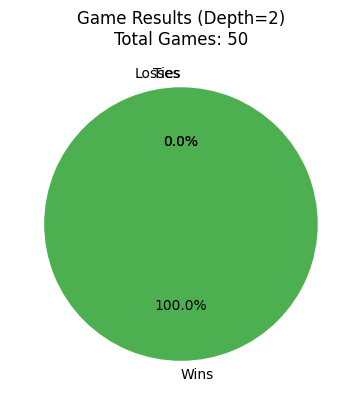

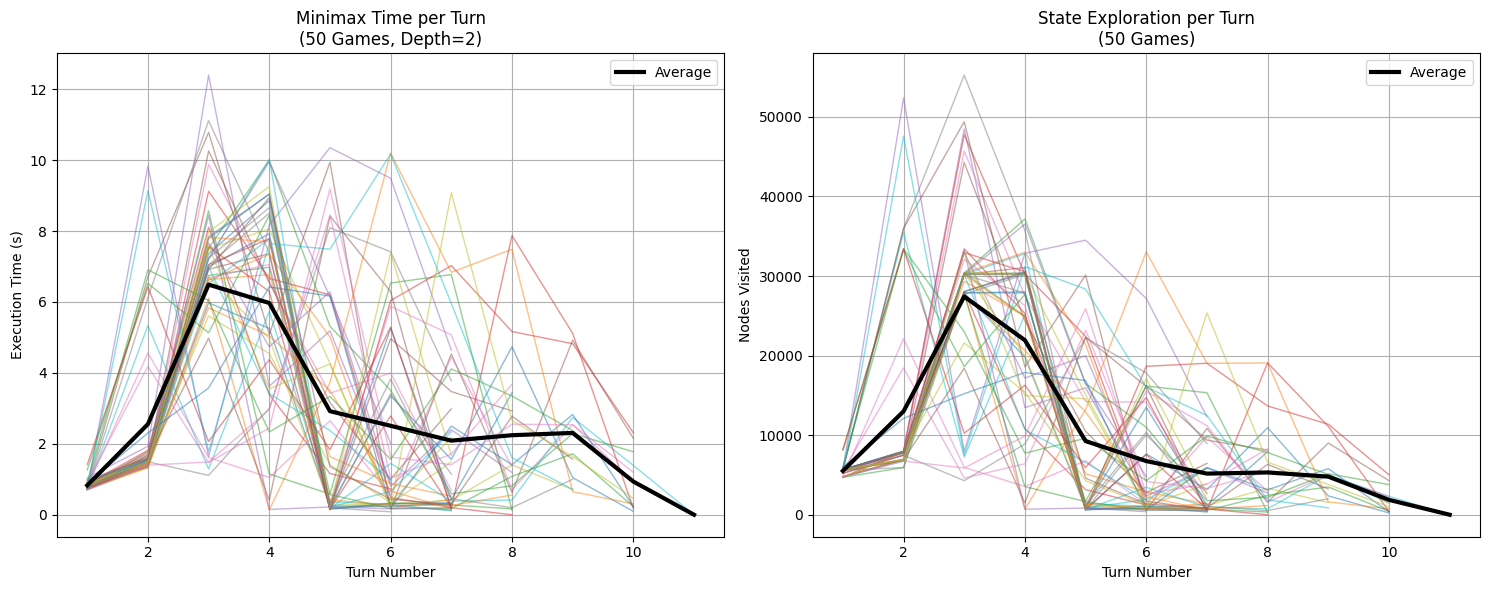

In [3]:
numGames = 50
depth = 2
numWins, numTies, numLosses = 0, 0, 0
all_games_metrics = []

for i in range(numGames):
    game = PentagoGame(ui=False, print=False, depth=depth)
    result = game.play(pruning=True)
    if result == -1:
        numWins += 1
    elif result == 0:
        numTies += 1
    else:
        numLosses += 1
    all_games_metrics.append(game.information)

# 1. Win/Lose/Tie Pie Chart
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
results = [numWins, numLosses, numTies]
labels = ['Wins', 'Losses', 'Ties']
colors = ['#4CAF50', '#F44336', '#FFC107']
plt.pie(results, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title(f'Game Results (Depth={depth})\nTotal Games: {numGames}')

# 1. Prepare Time/Nodes Data
max_turns = max(len(metrics) for metrics in all_games_metrics)
time_matrix = np.full((numGames, max_turns), np.nan)
nodes_matrix = np.full((numGames, max_turns), np.nan)

for i, metrics in enumerate(all_games_metrics):
    for j, m in enumerate(metrics):
        time_matrix[i,j] = m[1]
        nodes_matrix[i,j] = m[2]

# 2. Create Figure
plt.figure(figsize=(15, 6))

# Time Plot
plt.subplot(1, 2, 1)
for i in range(numGames):
    turns = np.arange(len(all_games_metrics[i])) + 1
    plt.plot(turns, time_matrix[i,:len(turns)], 
             alpha=0.5, linewidth=1)
    
# Add mean trendline
mean_time = np.nanmean(time_matrix, axis=0)
valid_turns = ~np.isnan(mean_time)
plt.plot(np.arange(max_turns)[valid_turns]+1, mean_time[valid_turns], 
         'k-', linewidth=3, label='Average')

plt.xlabel('Turn Number')
plt.ylabel('Execution Time (s)')
plt.title(f'Minimax Time per Turn\n({numGames} Games, Depth={depth})')
plt.grid(True)
plt.legend()

# Nodes Plot
plt.subplot(1, 2, 2)
for i in range(numGames):
    turns = np.arange(len(all_games_metrics[i])) + 1
    plt.plot(turns, nodes_matrix[i,:len(turns)], 
             alpha=0.5, linewidth=1)

# Add mean trendline
mean_nodes = np.nanmean(nodes_matrix, axis=0)
plt.plot(np.arange(max_turns)[valid_turns]+1, mean_nodes[valid_turns], 
         'k-', linewidth=3, label='Average')

plt.xlabel('Turn Number')
plt.ylabel('Nodes Visited')
plt.title(f'State Exploration per Turn\n({numGames} Games)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

### **<span style="color:rgb(223, 9, 84);">[Questions]</span>**

#### Q1
yes, as we see from the graphs of last part, we can summerise:
1. **relation between depth and time spent:** as we see with increasing the depth, the time that spent for game will groath exponantialy. the reason is that we are searching in a tree with high branching factor, and each successor have same size of branching. so the more we get deeper, the exponantialy successor we must visit.

2. **relation between depth winning rate:** as we can see, with increasing depth, we search much more children nodes, and the algorithm has more vision to make decision. so with increasing depth, our winning rate will increase.

3. **relation between depth and visited node:** it is obvious that with increasing depth, the number of visited node increase

#### Q2
Yes, we can significantly improve pruning efficiency through move ordering by Evaluate moves using a quick heuristic before full search and Sort moves by heuristic value (descending for MAX, ascending for MIN). it might be help to increase pruning

#### Q3 
branching factor is number of successors of each state. at the begining, we have $36×8$ branching factor for player 1. because we have 36 empty house to choice. it is obvious as long as we play the game, the number of our choice decreases because the empty houses becomes occupied. so the branching factor decreases as we continue the game.


#### Q4
The algorithm maintains two values, alpha and beta, which respectively represent the minimum score that the maximizing player is assured of and the maximum score that the minimizing player is assured of. Initially, alpha is negative infinity and beta is positive infinity, i.e. both players start with their worst possible score. Whenever the maximum score that the minimizing player (i.e. the "beta" player) is assured of becomes less than the minimum score that the maximizing player (i.e., the "alpha" player) is assured of (i.e. beta < alpha), the maximizing player need not consider further descendants of this node, as they will never be reached in the actual play.

#### Q5

because minmax algorithm designed for rational players. and the pleyer choose houses randomly, so its behavier is stochastic and Minimax is not good for stochastic player. for resolving the problem, we can Replace Minimax with Expectimax for optimal performance, Use MCTS if you need deeper lookahead with rotations, Never use pure Minimax—it's over-engineered for this scenario